In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean, std

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ignore known warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [3]:
# load in the dataset
features = pd.read_csv('heloc_dataset_v1.csv')

# Remove rows with missing values
df = features.drop(["RiskPerformance"], axis=1)

# Remove rows with the same value (all -9s)
rows_with_missing_values = df[df.apply(lambda x: min(x) == max(x), 1)]
features = features.drop(rows_with_missing_values.index.tolist())
features = features.reset_index(drop=True)

# Drop columns with correlation over 0.8 with lower feature importance
to_remove = ['NumTotalTrades', 'NumTrades90Ever/DerogPubRec', 'NumInqLast6Mexcl7days'] 
features = features.drop(to_remove, axis=1)

X = features[features.columns[1:]]
y = features["RiskPerformance"]

# columns categorization
categorical = ['MaxDelqEver', 'MaxDelq/PublicRecLast12M']
numerical = [col for col in X.columns if col not in categorical]

# Encode labels
y_code = y.astype("category").cat.codes

for cat in categorical:
    features[cat] = features[cat].astype("category")

In [4]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

model = RandomForestClassifier(n_estimators = 200, n_jobs=-1, max_features='sqrt')

transformer = ColumnTransformer(transformers=[('num', StandardScaler(), numerical), ('cat', OrdinalEncoder(), categorical)])

In [5]:
columns = list(numerical) + list(categorical)

X_transform = pd.DataFrame(transformer.fit_transform(X), columns=columns)

X_train_transformed, X_test_transformed, y_train, y_test = \
    train_test_split(X_transform, y_code, stratify=y_code, train_size = 0.9, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y_code, stratify=y_code, train_size = 0.9, random_state=0)

In [6]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
labelled_correctly = y_pred == y_test
y_pred_prob = model.predict_proba(X_test)[:, 1]

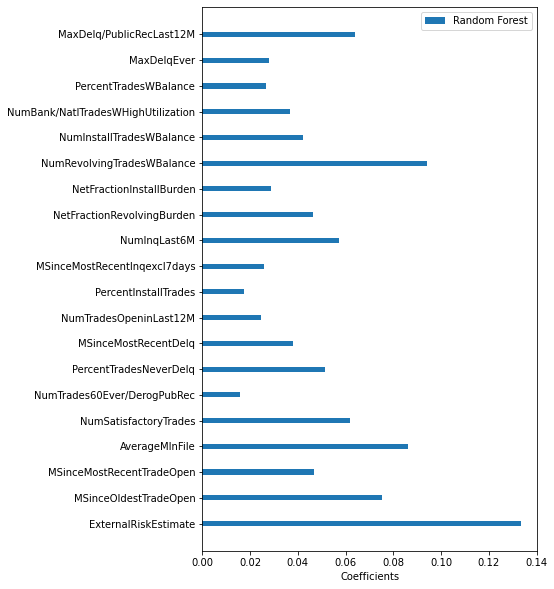

In [7]:
# Feature importances
df = pd.DataFrame({'names': columns, 
                   'random_forest': model.feature_importances_})

fig, ax = plt.subplots(figsize=(6, 10))
ind = np.arange(len(df))
width = 0.2
ax.barh(ind, df.random_forest, width, label='Random Forest')
ax.set_yticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_xlabel('Coefficients')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Permutation Importances (test set)')

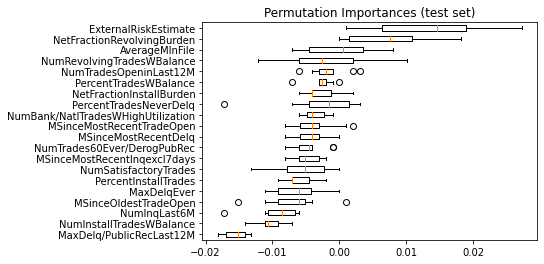

In [8]:
# Permutation Importances
from sklearn.inspection import permutation_importance
 
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0) # Takes a long time
sorted_idx = perm_importance.importances_mean.argsort()
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=np.array(columns)[sorted_idx])
plt.title("Permutation Importances (test set)")

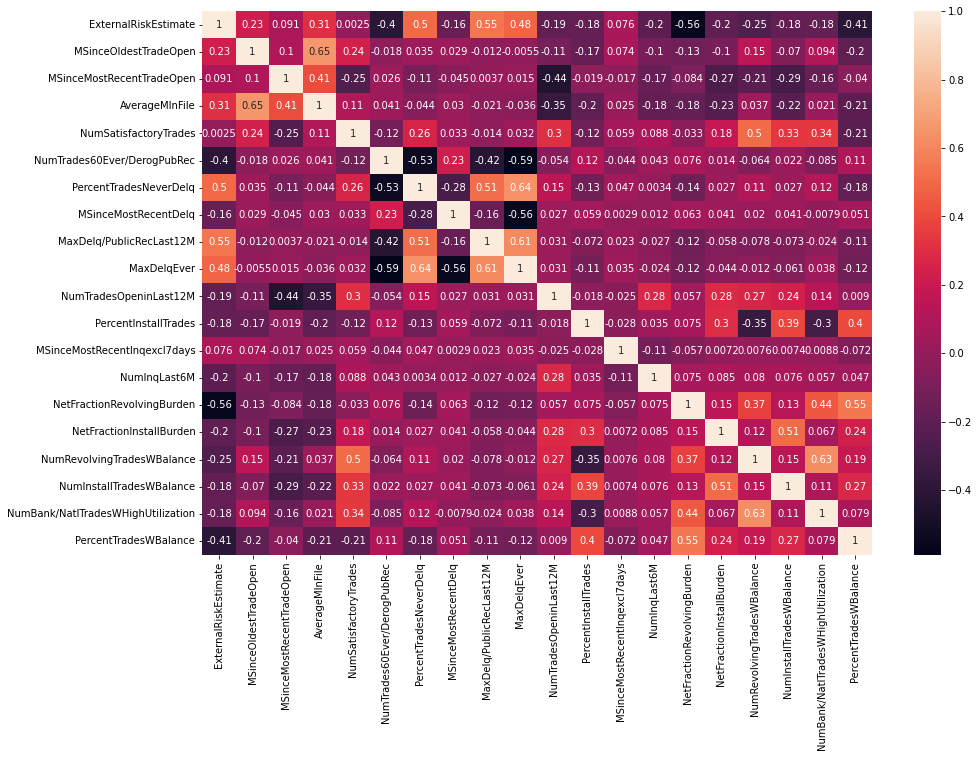

In [9]:
# Correlation matrix
import seaborn as sn
corrMatrix = X_train.corr()
plt.figure(figsize=(15, 10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_test_transformed)

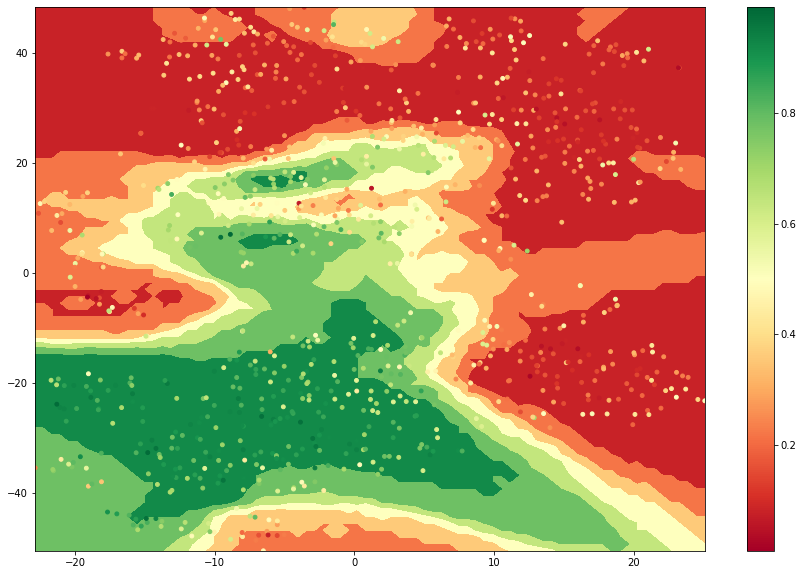

In [11]:
# Decision boundary using Voronoi tesselation
from sklearn.neighbors import KNeighborsClassifier

# create meshgrid
resolution = 80 
X2d_xmin, X2d_xmax = np.min(X_embed[:,0]), np.max(X_embed[:,0])
X2d_ymin, X2d_ymax = np.min(X_embed[:,1]), np.max(X_embed[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using KNN
background_model = KNeighborsClassifier(n_neighbors=20).fit(X_embed, y_pred) 
voronoiBackground = background_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, voronoiBackground, cmap='RdYlGn')
plt.scatter(X_embed[:,0], X_embed[:,1], c=y_pred_prob, s=15, cmap='RdYlGn')
plt.colorbar()
plt.show()

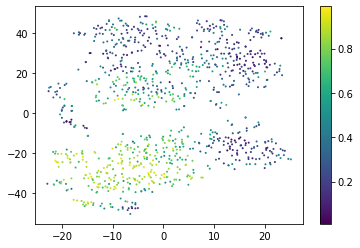

In [12]:
# Plot prediction probabilities across samples - also allow for other params!
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_pred_prob, s=1)
plt.colorbar()

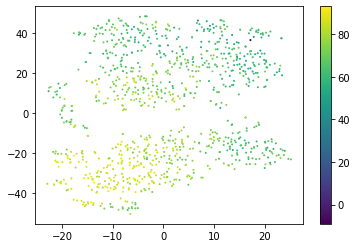

In [13]:
# labels - any of the col names
labels = X_test['ExternalRiskEstimate'].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

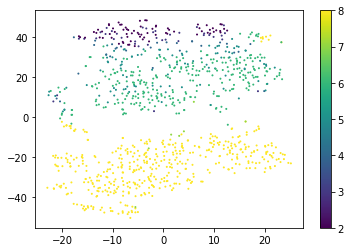

In [14]:
labels = X_test[categorical[0]].tolist()
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, s=1)
plt.colorbar()

In [15]:
# SHAP model (and local) explanations
import shap 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:100])[1] #Takes a very long time

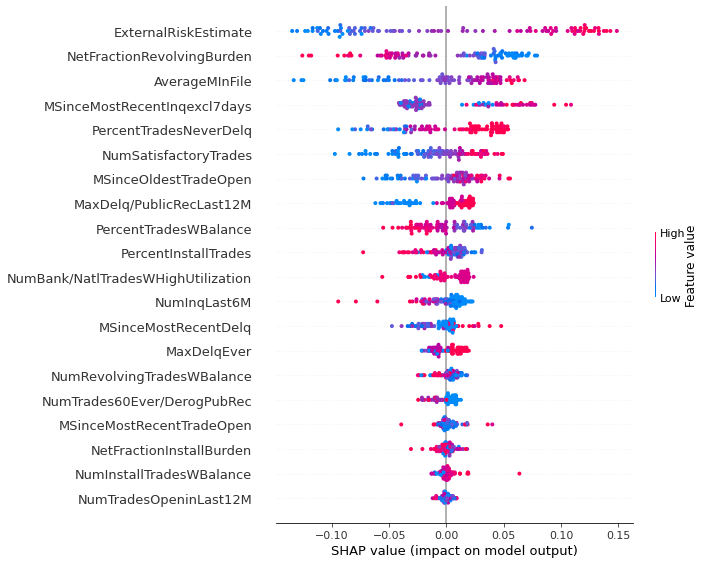

In [16]:
shap.summary_plot(shap_values, X_test[:100])

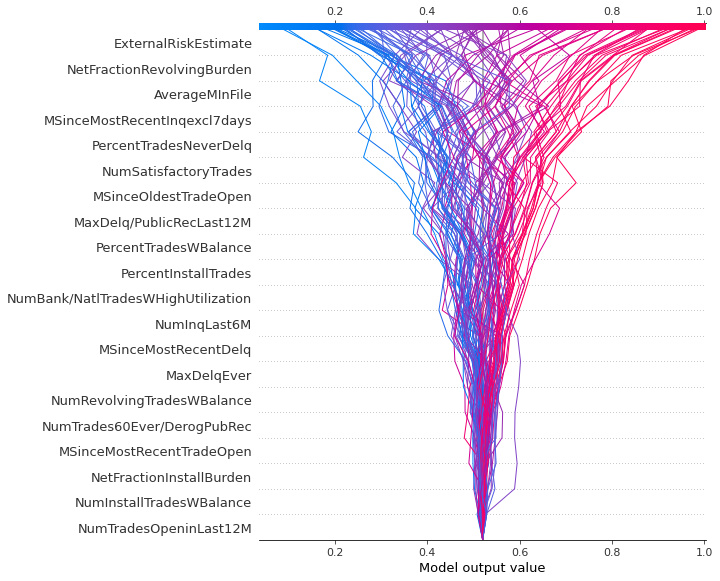

In [22]:
force_plot = shap.decision_plot(
            explainer.expected_value[0],
            shap_values,
            X_test,
            return_objects=True,
            show=False
        )

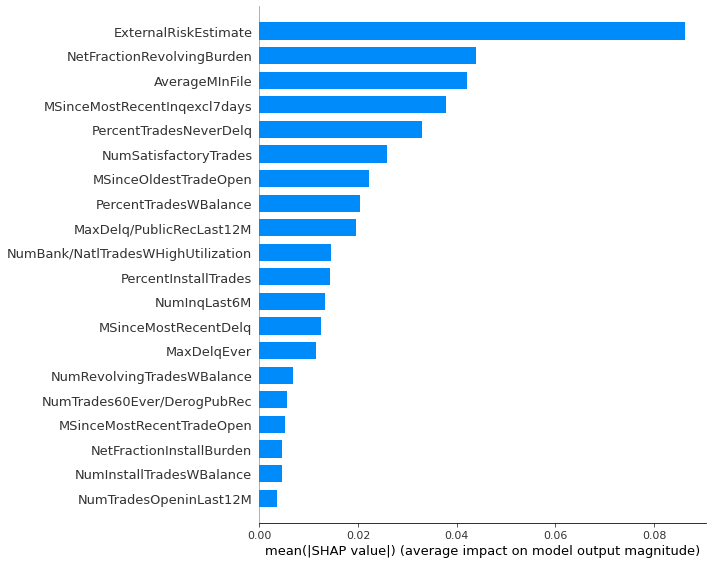

In [16]:
shap.summary_plot(shap_values, X_test[:100], plot_type="bar")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

In [ ]:
# Lime Local explanations
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    mode='classification', 
    feature_names=X_train.columns, 
    verbose=True
)

In [ ]:
exp = explainer.explain_instance(X_test.loc[3610], model.predict_proba)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
import plotly.express as px


explanations = [e[0] for e in exp.as_list()]
prob_values = [e[1] for e in exp.as_list()]
impact = ['positive' if e[1] > 0 else 'negative' for e in exp.as_list()]
d = {
    "Explanation": explanations,
    "Probability attributed": prob_values,
    "Impact": impact
}
fig = px.bar(
    data_frame=pd.DataFrame(d),
    y="Explanation",
    x="Probability attributed",
    orientation='h',
    color="Impact"
)
fig.show()

In [ ]:
# DiCE counterfactual explanations
from dice_ml import Data, Model, Dice

permitted_range_dict = {}
for col in numerical:
    col_min = max(min(X_train[col]), 0)
    col_max = max(X_train[col])
    permitted_range_dict[col] = [col_min, col_max]

df = X_train.copy()
df['y'] = y_train.copy()
data = Data(
    dataframe=df, 
    continuous_features=numerical, 
    outcome_name='y'
)
m = Model(model=model, backend='sklearn')
dice = Dice(data, m, method='random')
e = dice.generate_counterfactuals(
    X_test.loc[[3610]], 
    total_CFs=1, 
    desired_class="opposite", 
    permitted_range=permitted_range_dict
)

# As an improvement point for the future work in the report - 
# would be great if we could get counterfactual probability as well, it is a work in progress in the DiCE library

import json

d = json.loads(e.to_json())
n_x_cols = len(d['feature_names'])
cfs_list = d['cfs_list'][0][0][:n_x_cols]
test_data = d['test_data'][0][0][:n_x_cols]
cf_df = pd.DataFrame([test_data, cfs_list], columns=d['feature_names'], index=['Actual', 'Closest CounterFactual'])
nunique = cf_df.nunique()
cols_to_drop = nunique[nunique == 1].index
cf_df.drop(cols_to_drop, axis=1)

In [ ]:
cols = [
    "NumTrades60Ever/DerogPubRec",
    "NumTradesOpeninLast12M",
    "NumInqLast6M",
    "NumRevolvingTradesWBalance",
    "NumInstallTradesWBalance",
    "NumBank/NatlTradesWHighUtilization",
    "NumSatisfactoryTrades"
]
fig = px.scatter_matrix(
    data_frame=df,
    dimensions=cols,
    color="NumInqLast6M"
)
fig.show()